# Blood flow in arteries

## 1D conservation law approximation

We can approximate blood flow and pressure in a network of arteries by modelling arteries as 1D axisymmetric compliant tubes in a cylindrical coordinate system with radial direction $r$ and axial direction $z$. Flow is then governed by a system of conservation law equations of the general form 

$$\frac{\partial \boldsymbol{U}}{\partial t} + \frac{\partial \boldsymbol{F}}{\partial z} = \boldsymbol{S}$$

The full set of equations for blood flow in arteries is

$$\dfrac{\partial}{\partial t} \begin{pmatrix} A(z,t) \\ q(z,t) \end{pmatrix} + \dfrac{\partial}{\partial z} \begin{pmatrix} q(z,t)\\ \dfrac{q(z,t)^2}{A(z,t)} + \frac{f(r_0)}{\rho} \sqrt{A_0(z) A(z,t)} \end{pmatrix} =$$

$$\begin{pmatrix} 0 \\ -\dfrac{2 \pi \nu q(z,t) R(z,t)}{\delta A(z,t)} + \dfrac{1}{\rho} \left( 2 \sqrt{A(z,t)} \left( \sqrt{\pi} f(r_0) + \sqrt{A_0(z)} \frac{df(r_0)}{dr_0 } \right) - A(z,t) \dfrac{df(r_0)}{dr_0} \right) \dfrac{dr_0(z)}{dz} \end{pmatrix}.$$

with the state equation

$$p(z,t) - p_0 = \frac{4}{3} \frac{Eh}{r_0(z)} \left( 1 - \sqrt{\frac{A_0(z)}{A(z,t)}} \right)$$

This model is too complicated to implement in the space of this tutorial, however, we have a FEniCS implementation available that can be [downloaded from Github](https://github.com/KVSlab/bloodflow). We will use this Python package to illustrate the model.

In [1]:
# %load ./bloodflow-1.1/demo_arterybranch.py
import sys

import numpy as np
import configparser

import arteryfe as af


def main(config_location):
    """Read config-file.
    Run the necessary functions to compute the solution.
    :param string config_location: Location of config file
    """
    param = af.ParamParser(config_location)

    # Constructor parameters
    order = param.param['order']
    rc = param.param['rc']
    qc = param.param['qc']
    Ru = param.param['Ru']
    Rd = param.param['Rd']
    L = param.param['L']
    k1 = param.param['k1']
    k2 = param.param['k2']
    k3 = param.param['k3']
    rho = param.param['rho']
    nu = param.param['nu']
    p0 = param.param['p0']
    R1 = param.param['R1']
    R2 = param.param['R2']
    CT = param.param['CT']

    # Geometry parameters
    Nt = param.geo['Nt']
    Nx = param.geo['Nx']
    N_cycles = param.geo['N_cycles']

    # Solution parameters
    inlet_flow_location = param.solution['inlet_flow_location']
    output_location = param.solution['output_location']
    theta = param.solution['theta']
    Nt_store = param.solution['Nt_store']
    N_cycles_store = param.solution['N_cycles_store']
    store_area = param.solution['store_area']
    store_pressure = param.solution['store_pressure']

    # Import inlet flow data
    T, q_ins = af.read_inlet(inlet_flow_location, Nt)

    # Nondimensionalise data and compute Reynolds' number
    Ru, Rd, L, k1, k2, k3, Re, nu, p0, R1, R2, CT, q_ins, T =\
        af.nondimensionalise_parameters(rc, qc, Ru, Rd, L, k1, k2, k3,
                                   rho, nu, p0, R1, R2, CT, q_ins, T)

    # Create artery network
    an = af.ArteryNetwork(order, rc, qc, Ru, Rd, L, k1, k2,
                        k3,	rho, Re, nu, p0, R1, R2, CT)
    an.define_geometry(Nx, Nt, T, N_cycles)
    an.define_solution(output_location, q_ins[0], theta)

    # Solve problem and store data
    an.solve(q_ins, Nt_store, N_cycles_store, store_area, store_pressure)


if __name__ == '__main__':
    main(sys.argv[1])


ModuleNotFoundError: No module named 'arteryfe'

In [3]:
# %cd bloodflow-1.1/
# %run demo_arterybranch.py config/demo_arterybranch.cfg

/home/alexandra/projects/suurph-summer-school/SSCP_2019_master/Stream 1 (Cardiac Mechanics)/L22-23A/bloodflow-1.1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


In [ ]:
# %run postprocess.py output/4cycles_last/data.cfg

Flow:
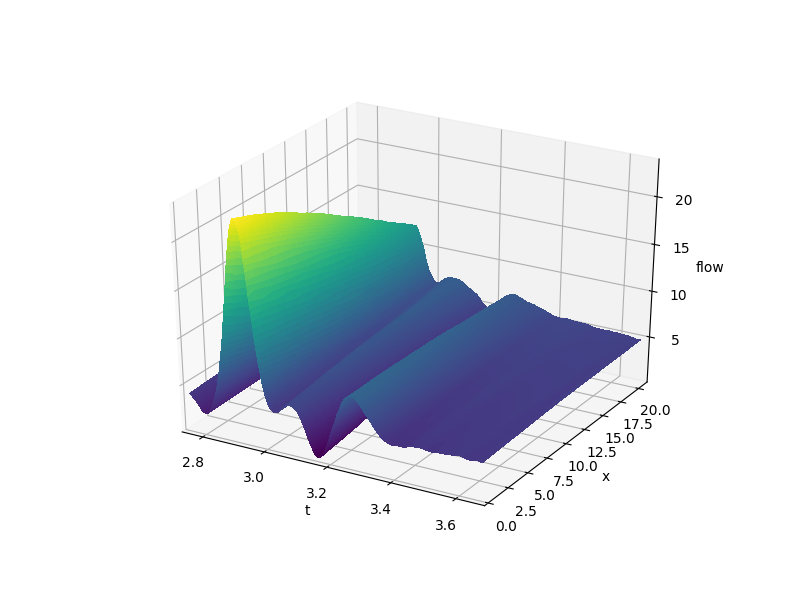

Area:
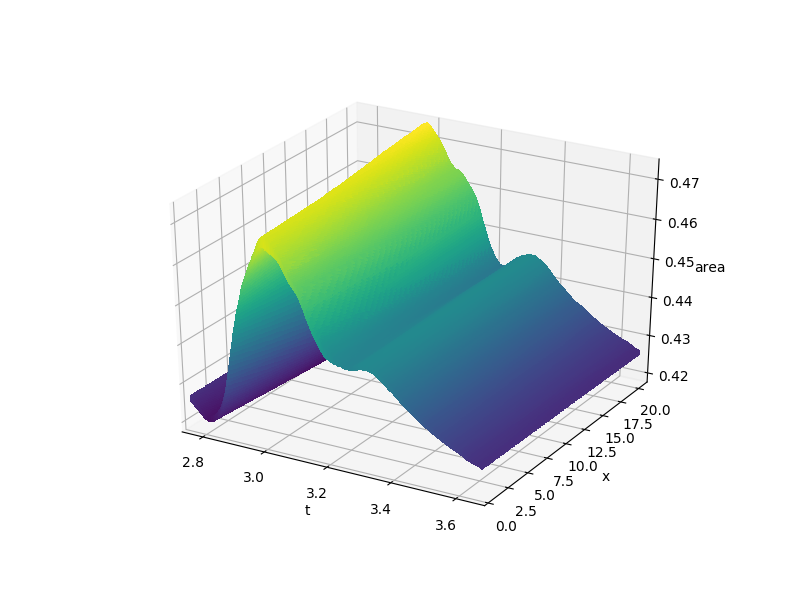

Pressure:
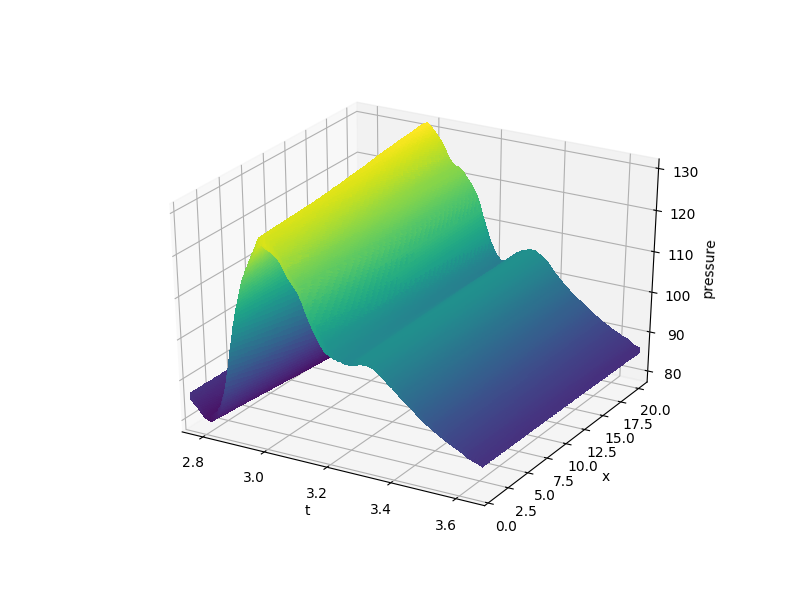

# Tissue perfusion

### Multi-compartment Darcy's law

Tissue is perfused by arteries, arterioles and capillaries ranging between 10 um and 1 mm in diameter, resulting in inhomogeneous porosity. To account for this inhomogeneous porosity we expand Darcy's law to a multi-compartment model using $N$ porous tissues that are superimposed in the model domain.

| <img src="figures/multicompartment.jpg" width=600> |
|:--:|
| *Illustration of a superimposition of N=3 porous compartments into a multi-compartment domain.* |

Taking the example of $N = 2$ compartments, we now have to solve for two Darcy equations that are coupled via the pressure gradients between the compartments, using coupling coefficients $\beta$:

$$\nabla \cdot \left( -\boldsymbol{K}_0 \; \nabla p_0(\boldsymbol{x}) \right) + \beta_{0,1} (p_0 - p_1) = f_0(\boldsymbol{x})  \qquad \text{on } \Omega$$
$$\nabla \cdot \left( -\boldsymbol{K}_1 \; \nabla p_1(\boldsymbol{x}) \right) + \beta_{0,1} (p_1 - p_0) = f_1(\boldsymbol{x})  \qquad \text{on } \Omega$$

To derive the variational form for a system of coupled equations we use separate sets of trial and test functions and then add up the equations, such that the variational problem reads: Find $p_0$, $p_1 \in V$ such that $\forall q_0, q_1 \in \hat{V}$

$$\langle - \boldsymbol{K}_0 \; \nabla p_0(\boldsymbol{x}), \nabla q_0 \rangle_{\Omega} + \langle - \boldsymbol{K}_1 \; \nabla p_1(\boldsymbol{x}), \nabla q_1 \rangle_{\Omega} + \langle \beta_{0,1} (p_0 - p_1), q_0 \rangle_{\Omega} + \langle \beta_{0,1} (p_1 - p_0), q_1 \rangle_{\Omega} = \langle f_0(\boldsymbol{x}), q_0 \rangle_{\Omega} + \langle f_1(\boldsymbol{x}), q_1 \rangle_{\Omega}$$

More generally the system of Darcy equations and their variational form can be written as

$$\nabla \cdot \left( -\boldsymbol{K}_i \; \nabla p_i(\boldsymbol{x}) \right) + \sum_{j=0}^N \beta_{i,j} (p_i - p_j) = f_i(\boldsymbol{x})  \qquad \text{on } \Omega$$

And: Find $p_i \in V$ such that $\forall q_i \in \hat{V}$

$$\sum_{i=0}^N \langle - \boldsymbol{K}_i \; \nabla p_i(\boldsymbol{x}), \nabla q_i \rangle_{\Omega} + \sum_{i=0}^N \sum_{j=0}^N \langle \beta_{i,j} (p_i - p_1j), q_i \rangle_{\Omega} = \langle \sum_{i=0}^N \langle f_i(\boldsymbol{x}), q_i \rangle_{\Omega}$$

With a particular interest in tissue perfusion we can apply some assumptions for the compartment coupling coefficients $\beta$:

$\beta_{i,i} = 0$

$\beta_{i,j} = \beta_{j,i}$

$\beta_{i+1,i} = 0$

#### Exercise: Discuss these assumptions with your neighbour.

### FEniCS implementation

In [1]:
from fenics import *
import numpy as np
import matplotlib.pyplot as plt

parameters["form_compiler"]["quadrature_degree"] = 4
parameters["form_compiler"]["cpp_optimize"] = True

Because pressures in the different compartments are coupled, solving the multi-compartment model requires a _mixed function space_. If each pressure variable should be approximated using P1 linear elements, then we have to use a mixed finite element containing $N$ P1 elements

In [ ]:
# Create mixed function spaces for a given mesh and number of compartments N
def mixed_function_space(mesh, N):
    P1 = FiniteElement('P', mesh.ufl_cell(), 1)
    ME = MixedElement([P1 for i in range(N)])
    return FunctionSpace(mesh, ME)

n = 4
mesh = UnitSquareMesh(n, n)
N = 3
V = mixed_function_space(mesh, N)
# To access individual function spaces: 
[print(type(V.sub(i))) for i in range(N)]

When using this mixed function space the corresponding trial/test functions will also be mixed

In [ ]:
p = TestFunction(V)
q = TrialFunction(V)
[print(type(p[i])) for i in range(N)]
[print(type(q[i])) for i in range(N)]

p = Function(V)
[print(type(p[i])) for i in range(N)]

#### Exercise: Copy over your code for Darcy's law from L13 and expand it to a multi-compartment model with N = 2

In [ ]:
# Create mesh and define function space
n = 4
mesh = UnitSquareMesh(n, n)
P1 = FiniteElement('P', mesh.ufl_cell(), 1)
ME = MixedElement([P1, P1])
P = FunctionSpace(mesh, ME) # mixed pressure space

# Define parameters
N = 2
K = [Constant(1), Constant(1)]
beta01 = Constant(0.2)
f = Constant(2)

# Define boundary condition
# Insert your code here

# Define variational problem
# Insert your code here

# Solve
# Uncomment two lines below to invoke solver
# p = Function(P)
# solve(a == L, p, bcs=bcs)

In [ ]:
# Plot solution p0
fig = plot(p[0])
plt.colorbar(fig)

In [ ]:
# Plot solution p1
fig = plot(p[1])
plt.colorbar(fig)

#### Exercise: Apply the multi-compartment Darcy's law model to the LV geometry from L21.

In [ ]:
def load_ellipsoid_data():
    """Returns 4-tuple:
    mesh - the mesh, 
    mf - MeshFunction defining boundary markers, 
    numbering - dict of marking numbers,
    fibers - list of functions defining microstructure"""
    import dolfin
  
    mesh = dolfin.Mesh(dolfin.MPI.comm_world, "../L20-21A/data/mesh.xml")
    mf = dolfin.MeshFunction("size_t", mesh, "../L20-21A/data/facet_function.xml")

    numbering = {
        "BASE": 10,
        "ENDO": 30,
        "EPI": 40
    }

    # load fibers, sheet, cross_sheet data 
    fiber_element = dolfin.VectorElement(family="Quadrature",
                                     cell=mesh.ufl_cell(),
                                     degree=4,
                                     quad_scheme="default")
    fiber_space = dolfin.FunctionSpace(mesh, fiber_element)
    fiber = dolfin.Function(fiber_space, "../L20-21A/data/fiber.xml")
    sheet = dolfin.Function(fiber_space, "../L20-21A/data/sheet.xml")
    cross_sheet = dolfin.Function(fiber_space, "../L20-21A/data/cross_sheet.xml")

    fibers = [fiber,sheet, cross_sheet]
    
    return mesh, mf, numbering, fibers

As in the previous lecture, load the geometry data using the function load_ellipsoid_data().

In [ ]:
# load geometry data
mesh, boundary_markers, numbering, fibers = load_ellipsoid_data()
P1 = FiniteElement('P', mesh.ufl_cell(), 1)
ME = MixedElement([P1, P1])
P = FunctionSpace(mesh, ME) # mixed pressure space

Apply your multi-compartment to this geometry and use the boundary_markers mesh function to apply your boundary conditions. These should be $p = 10500$ Pa at the epicardium in compartment 0 and $p = 3300$ Pa at the endocardium in compartment 1. To apply boundary conditions on a sub-space of a function space you can write for example

In [ ]:
bc = DirichletBC(P.sub(0), Constant(1), boundary_markers, 10)

In [ ]:
# Implement the multi-compartment Darcy's law model on the left ventricle geometry here

In [ ]:
# Plot solution p0
plot(mesh, alpha=0.1, edgecolor='k', color='w')
fig = plot(p[0])
plt.colorbar(fig)

ax = plt.gca()
ax.view_init(elev=-67, azim=-179)
ax.set_axis_off()
plt.show()

In [ ]:
# Plot solution p1
plot(mesh, alpha=0.1, edgecolor='k', color='w')
fig = plot(p[1])
plt.colorbar(fig)

ax = plt.gca()
ax.view_init(elev=-67, azim=-179)
ax.set_axis_off()
plt.show()

#### Exercise: Use your results from L21 (contraction modelling) to drive the perfusion model

To drive our model using the results from the solid contraction model from the previous lecture we will assume that pressure in compartment 0 is fully described by the stresses in the left ventricle tissue, so we only need to solve for p1. We can calculate stress and convert it to pressure using

In [ ]:
from guccionematerial import *

mesh, boundary_markers, numbering, fibers = load_ellipsoid_data()
V = VectorFunctionSpace(mesh, 'P', 1) # displacement space
P = FunctionSpace(mesh, 'P', 1) # pressure space

u = Function(V)
u_file = XDMFFile("contraction/u.xdmf")
u_file.read_checkpoint(u, 'u', 0)
u_file.close()

# Define strain measures
I = Identity(3) # the identity matrix
F = I + grad(u) # the deformation gradient
F = variable(F)
J = variable(det(F))

mat = GuccioneMaterial(e1=fibers[0],e2=fibers[1],e3=fibers[2],kappa=1e3,Tactive=0.0)
psi = mat.strain_energy(F)

p0 = project(inner(diff(psi, F), F.T), P)

In [ ]:
# Implement the multi-compartment Darcy's law model on the left ventricle geometry here